In [33]:
import optuna
import torch
import torchvision
import numpy as np
from torchvision import transforms, datasets

torch.manual_seed(69) #gives 61,5 % 

In [34]:
import torch
import os
from tqdm import tqdm_notebook #for progress bar
import torchvision
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


import optuna
from optuna.trial import TrialState

In [35]:
import torch.nn as nn
import torch.nn.functional as F


In [126]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# # device = torch.device("cpu")
# device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [119]:
training_folder = './data/training'
transform = transforms.Compose(
    
    [
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.05, contrast= 0.05, saturation= 0.05, hue = 0.05),
     transforms.ToTensor()
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ] 
    
)

transform2 = transforms.Compose(

    [
     transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
    ]
)

transformImageNet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformGoogle = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = datasets.ImageFolder(root=training_folder, transform=transformGoogle)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, shuffle = True)


In [120]:
test_folder = './data/validation'
testset = datasets.ImageFolder(root=test_folder, transform=transformGoogle)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, shuffle = True)

In [6]:
for images, labels in trainloader:
    print("Batch Shape:", images)
    print("Labels Shape:", labels)
    break

Batch Shape: tensor([[[[ 0.7933,  0.8961,  0.9303,  ...,  0.9988,  0.9817,  0.8961],
          [ 0.8104,  0.8618,  0.8618,  ...,  0.9303,  0.9303,  0.9474],
          [ 0.8447,  0.8447,  0.8789,  ...,  0.8961,  0.9646,  0.9303],
          ...,
          [-1.1589, -1.3815, -1.1760,  ..., -2.0152, -1.9980, -2.0152],
          [-1.3644, -1.4672, -1.1760,  ..., -2.0494, -2.0323, -1.9467],
          [-1.7412, -1.6213, -1.2445,  ..., -2.0665, -2.0665, -2.0152]],

         [[ 1.7458,  1.7983,  1.7983,  ...,  2.0434,  2.0259,  1.9384],
          [ 1.7283,  1.7633,  1.7633,  ...,  1.9734,  1.9734,  1.9909],
          [ 1.7458,  1.7458,  1.7808,  ...,  1.9384,  2.0084,  1.9734],
          ...,
          [-0.7927, -0.9853, -0.8452,  ..., -1.6856, -1.5455, -1.4930],
          [-0.9153, -1.0553, -0.8277,  ..., -1.7031, -1.7206, -1.3704],
          [-1.1078, -1.1429, -0.8627,  ..., -1.5455, -1.6506, -1.4230]],

         [[ 1.4722,  1.5420,  1.5594,  ...,  1.9254,  1.9080,  1.8208],
          [ 1.454

In [47]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 32, kernel_size = 5, stride = 3, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels= 32 , out_channels = 64, kernel_size = 5, stride = 3, padding=2) 
        self.bn2 = nn.BatchNorm2d(64)
        # self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(17 * 17 * 64, 1000)
        self.fc2 = nn.Linear(1000, 1)
        #self.fc3 = nn.Linear(30, 1)
        #self.fc2_2 = nn.Linear(1000, 1)
    
    
    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        #print(x.shape)
        x = x.view(-1, 17 * 17 * 64)
        # x = self.dropout(x)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc2(x))
        return x
        
        

In [48]:

#torch.manual_seed(1) #gives 59
batch = []
net = ConvNet().to(device)

batch = next(iter(trainloader))

net.forward(torch.FloatTensor(batch[0]).to(device))

RuntimeError: shape '[-1, 18496]' is invalid for input of size 131072

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()

learning_rate = 0.00010246617213508516 #for adam
#learning_rate = 1.71903735673968e-05 #for RMS
#learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.RMSprop(net.parameters(), lr = learning_rate)
losses = []

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(10, 1, 1)

for epoch in tqdm_notebook(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        
        X_batch, y_batch = batch
        y_batch = y_batch.float()

        optimizer.zero_grad()

        y_pred = net(X_batch)
 
        loss = loss_fn(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            losses.append(running_loss / 50)
            running_loss = 0.0
ax.plot(np.arange(len(losses)), losses)
plt.show()

In [ ]:
class_correct = [0,0]
class_total = [0,0]
classes = ['Real', 'Fake']


with torch.no_grad():
    for data in testloader:
        images, labels = data
        if len(labels) == 2:
            continue
        y_pred = net(images)

        predicted = torch.squeeze(torch.round(y_pred))

        c = predicted.cpu().detach() == labels
        
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

    for i in range(2):
        print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
    print(class_total)
    print(class_correct)
    print('Total Accuracy is: ', sum(class_correct) / sum(class_total))

In [ ]:
class OptunaModel(nn.Module):
    def __init__(self, input_size, output_size, num_conv_layers, trial):


        
        super(OptunaModel, self).__init__()
        
        in_channels = input_size
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            num_neurons = trial.suggest_int(f'num_neurons_layer_{_}', 128 // (1.5 ** i ), 512 // (1.5 ** i ))
            self.conv_layers.append(nn.Conv2d(input_size, num_neurons, kernel_size = 5, stride = 3, padding = 2 ))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
            in_channels = num_neurons
        
        self.flatten = nn.Flatten()
        self.l_layers = nn.ModuleList()
        
        self.output_layer = nn.Linear(in_channels, output_size)
        self.sigmoid = nn.Sigmoid()
        
        
        for i in range(2):
            num_neurons = trial.suggest_int(f'num_neurons_l_{i}', 64 // (1.5 ** i ), 512 // (1.5 ** i ))
            self.l_layers.append(nn.Linear(input_size, num_neurons))
            self.l_layers.append(nn.ReLU())
            in_channels = num_neurons
        
        self.output_layer = nn.Linear(in_channels, output_size)
        
        
    def forward(self, x):
        for layer in self.layers:
            x = layer[x]
        x = self.flatten(x)
        
        for layer in self.l_layers:
            x = layer[x]
            
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

def objective(trial):
    
    input_size = 3
    output_size = 1
    num_conv_layers = trial.suggest_int('num_layers', 2, 5)
    model = OptunaModel(input_size, output_size, num_conv_layers, trial).to(device)

    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr= 1e-4)
    

    for epoch in tqdm_notebook(range(10)):

        running_loss = 0.0
        for i, batch in enumerate(tqdm_notebook(trainloader)):
        
            X_batch, y_batch = batch
            y_batch = y_batch.float()
        
            optimizer.zero_grad()
        
            y_pred = net(X_batch)
        
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
        
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                losses.append(running_loss)
                running_loss = 0.0

    class_correct = [0,0]
    class_total = [0,0]
    classes = ['Real', 'Fake']

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if len(labels) == 2:
                continue
            y_pred = net(images)

            predicted = torch.squeeze(torch.round(y_pred))

            c = predicted.cpu().detach() == labels

            for i in range(3):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    return sum(class_correct) / sum(class_total)
            


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 2)

best_trial = study.best_trial
best_trial.value

In [ ]:
best_trial.params

In [ ]:
AlexnetTunned = models.alexnet(pretrained = True)


In [ ]:
AlexnetTunned

In [75]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs = 10):

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(10, 1, 1)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    acc = []



    for epoch in tqdm_notebook(range(num_epochs)):


        scheduler.step()
        running_loss = 0.0

        for i, batch in enumerate(tqdm_notebook(trainloader)):

            X_batch, y_batch = batch
            y_batch = y_batch.float()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 25 == 24:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                #losses.append(running_loss / 50)
                running_loss = 0.0


        class_correct = [0,0]
        class_total = [0,0]
        classes = ['Real', 'Fake']

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)

                y_pred = model(images)

                predicted = torch.squeeze(torch.round(y_pred))

                c = predicted.cpu().detach() == labels

                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        # for i in range(2):
        #     print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
        # print(class_total)
        # print(class_correct)
        print('Total Accuracy is: ', sum(class_correct) / sum(class_total))
        accuracy = sum(class_correct) / sum(class_total)
        acc.append( sum(class_correct) / sum(class_total))
        if accuracy > best_acc:
            best_acc = accuracy
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    ax.plot(np.arange(len(acc)), acc)
    plt.show()
    return model, acc




In [ ]:
num_features = 9126
AlexnetTunned.classifier = nn.Linear(num_features, 2)

if torch.cuda.is_available:
    AlexnetTunned = AlexnetTunned.to(device)
    
loss_fn2 = torch.nn.BCEWithLogitsLoss()

optimizer2 = optim.Adam(AlexnetTunned.parameters(), lr = 1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

In [ ]:
train_model(AlexnetTunned, loss_fn2, optimizer2, exp_lr_scheduler, num_epochs = 15)


In [42]:
model_vgg = models.vgg16(pretrained = True)

for param in model_vgg.features[:-1].parameters():
    param.requires_grad = False

num_features = 4096

model_vgg.classifier[-1] = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

print(model_vgg)
model_vgg = model_vgg.to(device)

loss_fn2 = torch.nn.BCEWithLogitsLoss()

optimizer2 = optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer2, step_size=8, gamma=0.5) #e-4, 0.1 = 65,6

/opt/anaconda3/envs/DeepFakesProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

/var/folders/k2/rg_zc5tn7j79wyy5g9q0kc_h0000gn/T/ipykernel_15621/2615219682.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/k2/rg_zc5tn7j79wyy5g9q0kc_h0000gn/T/ipykernel_15621/2615219682.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

[1,    50] loss: 0.692
[1,   100] loss: 0.694
Total Accuracy is:  0.6410256410256411


  0%|          | 0/116 [00:00<?, ?it/s]

[2,    50] loss: 0.683
[2,   100] loss: 0.683
Total Accuracy is:  0.5128205128205128


  0%|          | 0/116 [00:00<?, ?it/s]

[3,    50] loss: 0.675
[3,   100] loss: 0.682
Total Accuracy is:  0.6153846153846154


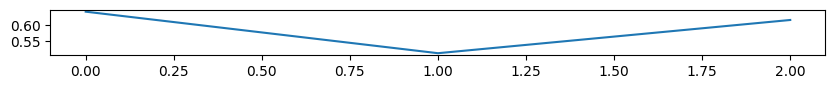

In [43]:
model_vgg, acc = train_model(model_vgg, loss_fn2, optimizer2, exp_lr_scheduler, num_epochs = 3) #gamma 1, 0.5

In [ ]:
model = models.vgg16(pretrained = True)


In [127]:
resnet = models.resnet18(pretrained = True) #best model gives 73% 
layer_to_unfreeze = 2
print(resnet)
for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.layer3.parameters():
    param.requires_grad = True

resnet.fc = nn.Sequential(
    nn.Linear(512, 1),
    nn.Sigmoid()
)

resnet = resnet.to(device)

loss_fn2 = torch.nn.BCEWithLogitsLoss()

optimizer3 = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer3, step_size=10, gamma=1) #e-4, 0.1 = 65,6

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/var/folders/k2/rg_zc5tn7j79wyy5g9q0kc_h0000gn/T/ipykernel_15621/4075259936.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/k2/rg_zc5tn7j79wyy5g9q0kc_h0000gn/T/ipykernel_15621/4075259936.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

[1,    25] loss: 0.258
[1,    50] loss: 0.263
[1,    75] loss: 0.264
[1,   100] loss: 0.257
Total Accuracy is:  0.675


  0%|          | 0/116 [00:00<?, ?it/s]

[2,    25] loss: 0.260
[2,    50] loss: 0.255
[2,    75] loss: 0.261
[2,   100] loss: 0.264
Total Accuracy is:  0.68


  0%|          | 0/116 [00:00<?, ?it/s]

[3,    25] loss: 0.253
[3,    50] loss: 0.255
[3,    75] loss: 0.260
[3,   100] loss: 0.257
Total Accuracy is:  0.675


  0%|          | 0/116 [00:00<?, ?it/s]

[4,    25] loss: 0.258
[4,    50] loss: 0.253
[4,    75] loss: 0.249
[4,   100] loss: 0.250
Total Accuracy is:  0.715


  0%|          | 0/116 [00:00<?, ?it/s]

[5,    25] loss: 0.253
[5,    50] loss: 0.261
[5,    75] loss: 0.259
[5,   100] loss: 0.246
Total Accuracy is:  0.67


  0%|          | 0/116 [00:00<?, ?it/s]

[6,    25] loss: 0.259
[6,    50] loss: 0.250
[6,    75] loss: 0.253
[6,   100] loss: 0.253
Total Accuracy is:  0.67


  0%|          | 0/116 [00:00<?, ?it/s]

[7,    25] loss: 0.249
[7,    50] loss: 0.247
[7,    75] loss: 0.250
[7,   100] loss: 0.258
Total Accuracy is:  0.685


  0%|          | 0/116 [00:00<?, ?it/s]

[8,    25] loss: 0.251
[8,    50] loss: 0.253
[8,    75] loss: 0.249
[8,   100] loss: 0.250
Total Accuracy is:  0.69


  0%|          | 0/116 [00:00<?, ?it/s]

[9,    25] loss: 0.255
[9,    50] loss: 0.248
[9,    75] loss: 0.249
[9,   100] loss: 0.248
Total Accuracy is:  0.685


  0%|          | 0/116 [00:00<?, ?it/s]

[10,    25] loss: 0.256
[10,    50] loss: 0.250
[10,    75] loss: 0.248
[10,   100] loss: 0.248
Total Accuracy is:  0.66


  0%|          | 0/116 [00:00<?, ?it/s]

[11,    25] loss: 0.246
[11,    50] loss: 0.247
[11,    75] loss: 0.250
[11,   100] loss: 0.252
Total Accuracy is:  0.705


  0%|          | 0/116 [00:00<?, ?it/s]

[12,    25] loss: 0.251
[12,    50] loss: 0.246
[12,    75] loss: 0.252
[12,   100] loss: 0.250
Total Accuracy is:  0.645


  0%|          | 0/116 [00:00<?, ?it/s]

[13,    25] loss: 0.248
[13,    50] loss: 0.243
[13,    75] loss: 0.259
[13,   100] loss: 0.245
Total Accuracy is:  0.69


  0%|          | 0/116 [00:00<?, ?it/s]

[14,    25] loss: 0.253
[14,    50] loss: 0.250
[14,    75] loss: 0.245
[14,   100] loss: 0.247
Total Accuracy is:  0.675


  0%|          | 0/116 [00:00<?, ?it/s]

[15,    25] loss: 0.258
[15,    50] loss: 0.248
[15,    75] loss: 0.249
[15,   100] loss: 0.244
Total Accuracy is:  0.685


  0%|          | 0/116 [00:00<?, ?it/s]

[16,    25] loss: 0.252
[16,    50] loss: 0.248
[16,    75] loss: 0.248
[16,   100] loss: 0.248
Total Accuracy is:  0.66


  0%|          | 0/116 [00:00<?, ?it/s]

[17,    25] loss: 0.253
[17,    50] loss: 0.249
[17,    75] loss: 0.250
[17,   100] loss: 0.247
Total Accuracy is:  0.645


  0%|          | 0/116 [00:00<?, ?it/s]

[18,    25] loss: 0.248
[18,    50] loss: 0.242
[18,    75] loss: 0.255
[18,   100] loss: 0.247
Total Accuracy is:  0.695


  0%|          | 0/116 [00:00<?, ?it/s]

[19,    25] loss: 0.243
[19,    50] loss: 0.247
[19,    75] loss: 0.253
[19,   100] loss: 0.249
Total Accuracy is:  0.68


  0%|          | 0/116 [00:00<?, ?it/s]

[20,    25] loss: 0.250
[20,    50] loss: 0.253
[20,    75] loss: 0.239
[20,   100] loss: 0.247
Total Accuracy is:  0.69


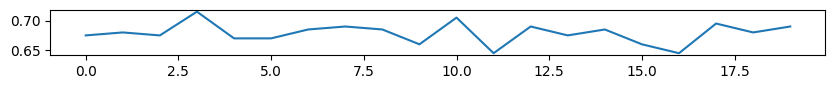

In [129]:
resnet, acc = train_model(resnet, loss_fn2, optimizer3, exp_lr_scheduler, num_epochs = 20) #gamma 1, 0.5

In [130]:
torch.save(resnet.state_dict(), 'resnet_71,5_on50epoch_three_last_layer_SGD(0.001, 09)_gamma 1, batch_size = 16 Imagenet.pth')



In [132]:
class_correct = [0,0]
class_total = [0,0]
classes = ['Real', 'Fake']

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        if len(labels) == 2:
            continue
        y_pred = resnet(images)


        predicted = torch.squeeze(torch.round(y_pred))
        # print(predicted)
        # print(labels)
        c = predicted.cpu().detach() == labels


        #print(labels)
        for i in range(len(labels)):

            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(class_correct, class_total)
print(sum(class_correct) / sum(class_total))


[64, 65] [100, 100]
0.645


In [105]:
torch.save(resnet.state_dict(), 'resnet_73_on50epoch_two_last_layer_SGD(0.001, 09)_gamma 1, batch_size = 16 Imagenet.pth')

In [113]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import Adam, lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


resnet2 = models.resnet18(pretrained=True)


resnet2.fc = nn.Sequential(
    nn.Linear(resnet2.fc.in_features, 1),  
    nn.Sigmoid()
)


classifier_params = list(resnet2.fc.parameters())
other_params = [param for param in resnet2.parameters() if param not in classifier_params]

optimizer3 = Adam([
    {'params': classifier_params},
    {'params': other_params, 'lr': 1e-5}
], lr=1e-4)

resnet2 = resnet2.to(device)

loss_fn2 = nn.BCEWithLogitsLoss()


exp_lr_scheduler = lr_scheduler.StepLR(optimizer3, step_size=7, gamma=0.1)


RuntimeError: The size of tensor a (512) must match the size of tensor b (7) at non-singleton dimension 3

In [49]:
resnet2, acc = train_model(resnet2, loss_fn2, optimizer3, exp_lr_scheduler, num_epochs = 25) #gamma 1, 0.5

NameError: name 'optimizer3' is not defined

In [121]:
googleNet = models.inception_v3(pretrained = True)
print(googleNet)
for param in googleNet.parameters():
    param.requires_grad = False

num_features = googleNet.fc.in_features

googleNet.fc = nn.Sequential(
    nn.Linear(2048, 1),
    nn.Sigmoid()
)


num_features = 25088
# googleNet.classifier[-1] = nn.Sequential(
#     nn.Linear(num_features, 1),
#     nn.Sigmoid()
# )
        

googleNet = googleNet.to(device)

loss_fn2 = torch.nn.BCEWithLogitsLoss()

optimizer2 = optim.Adam(googleNet.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1) #e-4, 0.1 = 65,6

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

/var/folders/k2/rg_zc5tn7j79wyy5g9q0kc_h0000gn/T/ipykernel_15621/4075259936.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/k2/rg_zc5tn7j79wyy5g9q0kc_h0000gn/T/ipykernel_15621/4075259936.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

KeyboardInterrupt: 

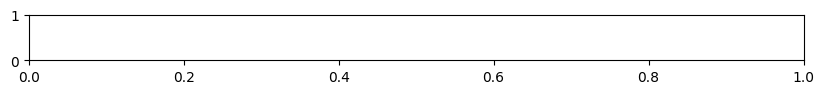

In [122]:
googleNet.aux_logits = False
googleNet, acc = train_model(googleNet, loss_fn2, optimizer2, exp_lr_scheduler, num_epochs = 25) 

In [136]:
best_model = models.resnet18(pretrained = True)
for param in best_model.parameters():
    param.requires_grad = False

for param in best_model.layer4.parameters():
    param.requires_grad = True

for param in best_model.layer3.parameters():
    param.requires_grad = True
    
best_model.fc = nn.Sequential(
    nn.Linear(512, 1),
    nn.Sigmoid()
)

best_model = best_model.to(device)
best_model.load_state_dict(torch.load('/Users/danielbelikov/DataspellProjects/DeepFakesProject/resnet_73_on50epoch_two_last_layer_SGD(0.001, 09)_gamma 1, batch_size = 16 Imagenet.pth', map_location=torch.device('mps')))
best_model.eval()


# loss_fn = torch.nn.BCEWithLogitsLoss()
# best_optimizer = optim.SGD(params=best_model.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(best_optimizer, step_size=10, gamma=0.1)

class_correct = [0,0]
class_total = [0,0]
classes = ['Real', 'Fake']

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        
        if len(labels) == 2:
            continue
        y_pred = best_model(images)
        

        predicted = torch.squeeze(torch.round(y_pred))
        # print(predicted)
        # print(labels)
        c = predicted.cpu().detach() == labels
        
        
        #print(labels)
        for i in range(len(labels)):
            
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(class_correct, class_total)
print(sum(class_correct) / sum(class_total)) 

[2, 99] [100, 100]
0.505
